In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.0 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.23.5
!pip install pmdarima --no-cache-dir


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 23.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# Eval Function

In [ ]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [ ]:
def train_test_valid(data):
  test_size  = 0.2
  valid_size = 0.1

  test_split_idx  = int(data.shape[0] * (1-test_size))
  valid_split_idx = int(data.shape[0] * (1-(valid_size+test_size)))

  return data[:valid_split_idx], data[valid_split_idx:test_split_idx+1], data[test_split_idx+1:]

# HoaPhat_HPG

## Data

In [ ]:
df_amz = pd.read_csv("/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Data/cleandata/HoaPhat_HPG_y_m_d.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,10260.39,10443.02,10227.19,10227.19,10227.19,12637219.0
1,2019-01-03,10210.59,10260.39,9795.52,9795.52,9795.52,21178963.0
2,2019-01-04,9762.32,9961.55,9529.88,9861.93,9861.93,20085098.0
3,2019-01-07,10061.16,10077.77,9679.30,9745.71,9745.71,7495579.0
4,2019-01-08,9762.32,9795.52,9529.88,9579.69,9579.69,12767952.0
...,...,...,...,...,...,...,...
1537,2025-03-06,27600.00,27950.00,27600.00,27950.00,27950.00,37159600.0
1538,2025-03-07,28000.00,28100.00,27750.00,28050.00,28050.00,33131210.0
1539,2025-03-10,28100.00,28200.00,27950.00,27950.00,27950.00,23863520.0
1540,2025-03-11,27600.00,28150.00,27600.00,28150.00,28150.00,26088500.0


## Preprocessing

### Check null and na value

In [ ]:
df_amz.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_amz.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [ ]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [ ]:
close_amz=df_amz[['Close']]

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2019-01-02 00:00:00
Ending date:  2025-03-12 00:00:00
Duration:  2261 days 00:00:00


<ipython-input-11-e30130b711a2>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",df_amz.iloc[0][0])
<ipython-input-11-e30130b711a2>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", df_amz.iloc[-1][0])
<ipython-input-11-e30130b711a2>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])


### Visualize the per day closing price of the stock

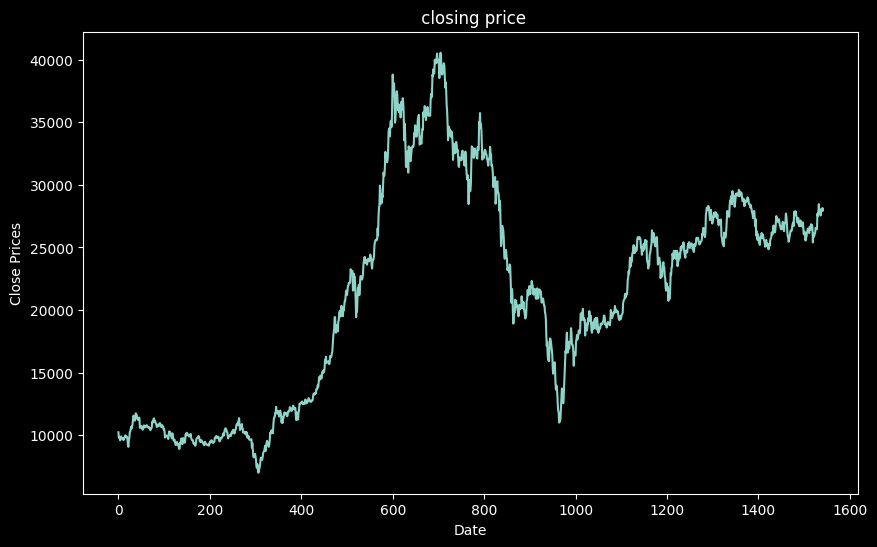

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(close_amz)
plt.title(' closing price')
plt.show()

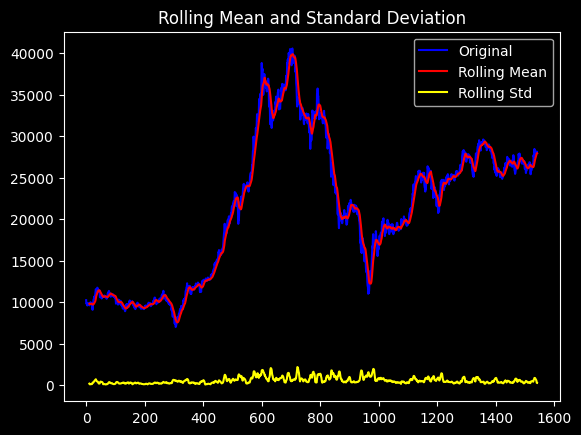

Results of dickey fuller test
Test Statistics                  -1.497438
p-value                           0.534778
No. of lags used                 15.000000
Number of observations used    1526.000000
critical value (1%)              -3.434642
critical value (5%)              -2.863436
critical value (10%)             -2.567779
dtype: float64


In [ ]:
test_stationarity(close_amz)

## Train, test, valid

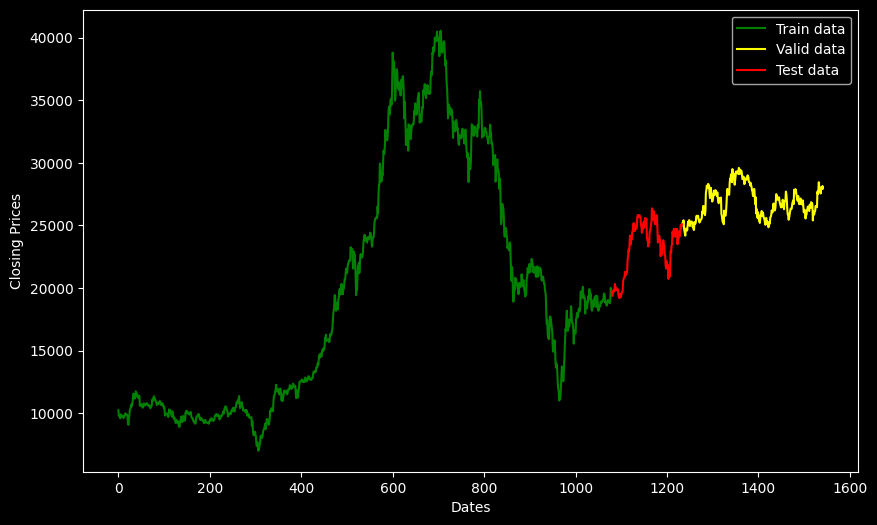

In [ ]:
close_amz = close_amz.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_amz)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [ ]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [ ]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_amz[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=24601.822, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16435.698, Time=0.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16433.829, Time=0.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=16435.294, Time=0.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=16435.209, Time=0.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16431.819, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.92 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16433.508, Time=0.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=2.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=16433.640, Time=3.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=16431.841, Time=1.07 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 12.441 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1079
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -8211.910
Date:                Thu, 17 Apr 2025   AIC                          16431.819
Time:                        09:09:27   BIC                          16451.754
Sample:                             0   HQIC                         16439.368
                               - 1079                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.000   2088.145      0.000       0.999       1.001
ma.L1          0.0502      0.020      2.477      0.013       0.010       0.090
ma.L2         -0.0711      0.023     -3.053      0.002      -0.117      -0.025
sigma2      2.372e+05   6373.753     37.220      0.000    2.25e+05     2.5e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               471.25
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               8.22   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [ ]:
model = ARIMA(y_train, order=(1,0,1),exog=df_amz[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1079
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7150.461
Date:                Thu, 17 Apr 2025   AIC                          14314.922
Time:                        09:09:31   BIC                          14349.808
Sample:                             0   HQIC                         14328.132
                               - 1079                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.5192     17.678      0.934      0.350     -18.129      51.168
High           0.8685      0.015     58.904      0.000       0.840       0.897
Open          -0.6783      0.015    -43.869      0.000      -0.709      -0.648
Low            0.8071      0.013     63.376      0.000       0.782       0.832
ar.L1         -0.2529      0.313     -0.808      0.419      -0.866       0.360
ma.L1          0.1848      0.317      0.583      0.560      -0.436       0.805
sigma2      3.346e+04    938.204     35.669      0.000    3.16e+04    3.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               496.62
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.46   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_amz[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=df_amz[['High','Open','Low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [ ]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  156.90776028528649
MAPE:  0.6669610057713803
RMSE:  203.67376428629038

** Validate **
MAE:  113.83457275695774
MAPE:  0.42266433568154493
RMSE:  146.69575116203728


## Forecast

Cách dùng exog	Độ khớp	Mức ổn định	Dễ triển khai

| Cách dùng exog | 	Độ khớp | 	Mức ổn định |Dễ triển khai |
|-------|-------|-------|-------|
| 30 ngày exog thật| ✅ Rất tốt | 	✅ Ổn định |  ✅ Dễ  |
| 30 ngày exog dự báo (auto_arima) | ❌ Kém | 	❌ Dao động mạnh | 	⚠️ Phức tạp |
| Hybrid (10 thật + 20 dự báo) | ❌ Không đều | 		⚠️ Trung bình | 	⚠️ Cồng kềnh |

Nên dùng cách 1:

**Cách 2 – Dự báo exog rồi dùng để forecast
✅ Khi nào nên dùng:**

Khi cần **dự báo xa (future forecasting) và không có sẵn exog thật**.

Khi làm dự án sản phẩm thực tế: hệ thống cần dự báo tự động, ví dụ như:

Dự báo giá cổ phiếu 30 ngày tới → nhưng hôm nay là ngày T, nên exog từ T+1 trở đi là chưa biết → phải dự báo exog trước rồi mới dự báo Close.

Dự báo nhu cầu bán hàng, dựa trên các chỉ số thị trường, thời tiết,… → các biến này cũng cần được forecast trước.

⚠️ Nhược điểm:
Nếu dự báo exog kém chính xác, nó sẽ kéo forecast chính cũng sai theo (cộng dồn lỗi).

Tương tự như domino: bước đầu sai thì bước sau càng lệch.


**Cách 3: hybrid (dùng 1 phần exog thật, 1 phần exog dự báo)
✅ Khi nào nên dùng:**

Khi bạn đang ở điểm **"quá độ":**

Ví dụ: hôm nay là ngày T → bạn biết exog trong 10 ngày tới (T+1 đến T+10) do có kế hoạch, lịch trình sẵn.

Nhưng từ T+11 đến T+30 thì chưa có, cần dự đoán.

Trong thực tế, nhiều hệ thống biết trước một phần biến độc lập, ví dụ:

Lịch mở bán sản phẩm, sự kiện sắp diễn ra, dự báo thời tiết gần…

Giá điện, lịch trình cung ứng đã có kế hoạch trước vài ngày.

⚠️ Nhược điểm:
Dễ bị gãy trend nếu phần exog dự báo không khớp với phần thật → như cậu thấy trong biểu đồ ấy.

Cần xử lý cẩn thận phần chuyển tiếp.


**Ở đây mình sẽ sử dụng cách 1 và cách 2 để so sánh 2 cách dự đoán**


####CÁCH 1 – DỰ BÁO TIẾP NỐI TỪ DỮ LIỆU THẬT
Cách này giả định exog tương lai bằng dữ liệu cũ gần nhất – tức là biến động vẫn theo thực tế gần nhất.


In [ ]:
last_index =  close_amz.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
# Giả sử mô hình đã train là: model
forecast_days = 30

# Cung cấp exog thật (từ 30 ngày gần nhất để khớp độ dài)
exog_real = df_amz[['High', 'Open', 'Low']].iloc[-forecast_days:]

# Dự báo tiếp nối
y_next_30_days = model.forecast(
    steps=forecast_days,
    exog=exog_real
)

print("✅ Dự báo tiếp nối với dữ liệu exog thật:")
print(y_next_30_days)


✅ Dự báo tiếp nối với dữ liệu exog thật:
1079    26580.385617
1080    26431.343086
1081    26328.015714
1082    26836.881714
1083    26841.578402
1084    26832.076383
1085    26580.739694
1086    25555.173912
1087    25960.407801
1088    25861.338212
1089    25857.232281
1090    26137.085436
1091    26100.100487
1092    26470.170380
1093    26381.294794
1094    26495.923029
1095    26415.212097
1096    27632.667967
1097    27303.944622
1098    27803.548438
1099    28142.465801
1100    27974.523308
1101    28122.030565
1102    27665.849860
1103    27590.538809
1104    27843.903904
1105    27823.901206
1106    28004.334685
1107    28017.596349
1108    27855.789146
Name: predicted_mean, dtype: float64


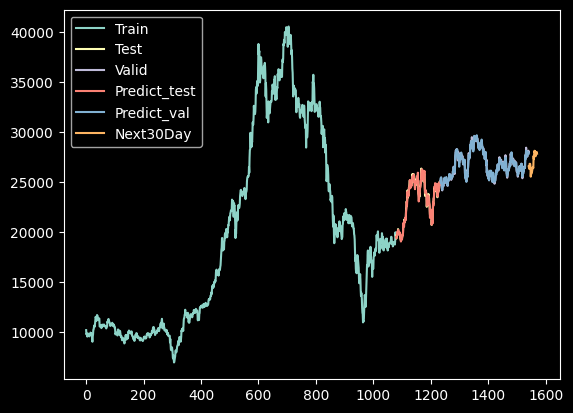

In [ ]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

####CÁCH 2 – DỰ BÁO ĐỘC LẬP NHƯNG MỀM MẠI HƠN

In [ ]:
# Copy lại DataFrame
df = df_amz.copy()
forecast_days = 30

# Dự báo từng biến exog bằng auto_arima
def forecast_feature(series, n_days):
    model = auto_arima(series,
                       start_p=1, start_q=1,
                       max_p=5, max_q=5,
                       seasonal=False,
                       d=None,
                       trace=False,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
    forecast = model.predict(n_periods=n_days)
    return forecast

# Dự báo High, Open, Low cho 30 ngày tới
forecast_high = forecast_feature(df['High'], forecast_days)
forecast_open = forecast_feature(df['Open'], forecast_days)
forecast_low = forecast_feature(df['Low'], forecast_days)

# Tạo DataFrame exog dự báo
exog_future = pd.DataFrame({
    'High': forecast_high,
    'Open': forecast_open,
    'Low': forecast_low
})

# Dự báo giá Close từ exog đã dự đoán
y_next_30_days = model.forecast(
    steps=forecast_days,
    exog=exog_future
)

print("🔄 Dự báo 30 ngày tới (dùng exog dự báo):")
print(y_next_30_days)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

🔄 Dự báo 30 ngày tới (dùng exog dự báo):
1079    27961.312814
1080    27956.786612
1081    27960.756138
1082    27975.636724
1083    27989.375728
1084    28000.922805
1085    28011.764476
1086    28022.230772
1087    28032.177648
1088    28041.579343
1089    28050.481477
1090    28058.919035
1091    28066.914868
1092    28074.490843
1093    28081.669078
1094    28088.470633
1095    28094.915279
1096    28101.021722
1097    28106.807707
1098    28112.290054
1099    28117.484699
1100    28122.406739
1101    28127.070479
1102    28131.489476
1103    28135.676571
1104    28139.643936
1105    28143.403102
1106    28146.964993
1107    28150.339963
1108    28153.537822
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


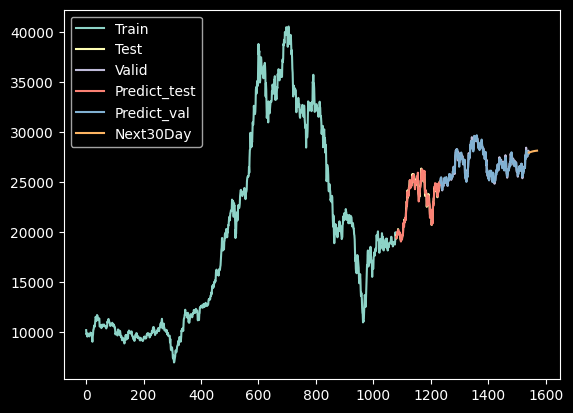

In [ ]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

# NamKim_NKG

## Data

In [ ]:
df_tsla = pd.read_csv("/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Data/cleandata/NamKim_NKG_y_m_d.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,4565.97,4577.55,4403.94,4403.94,4403.94,65576.0
1,2019-01-03,4403.94,4496.53,4195.60,4195.60,4195.60,559110.0
2,2019-01-04,4195.60,4195.60,3946.76,4079.86,4079.86,116707.0
3,2019-01-07,4079.86,4224.54,4079.86,4079.86,4079.86,132570.0
4,2019-01-08,4079.86,4155.09,4056.71,4079.86,4079.86,137979.0
...,...,...,...,...,...,...,...
1540,2025-03-06,15550.00,16100.00,15500.00,16100.00,16100.00,14202800.0
1541,2025-03-07,16050.00,16300.00,15900.00,16100.00,16100.00,10169700.0
1542,2025-03-10,16150.00,16200.00,15700.00,15800.00,15800.00,9795200.0
1543,2025-03-11,15500.00,16100.00,15400.00,16100.00,16100.00,14542500.0


## Preprocessing

### Check null and na value

In [ ]:
df_tsla.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_tsla.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [ ]:
df_tsla['Date'] = pd.to_datetime(df_tsla.Date)

### Choose X

In [ ]:
close_tsla=df_tsla[['Close']]

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])
print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])

Starting date:  2019-01-02 00:00:00
Ending date:  2025-03-12 00:00:00
Duration:  2261 days 00:00:00


<ipython-input-31-72eea4c1fa3f>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",df_tsla.iloc[0][0])
<ipython-input-31-72eea4c1fa3f>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", df_tsla.iloc[-1][0])
<ipython-input-31-72eea4c1fa3f>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])


### Visualize the per day closing price of the stock

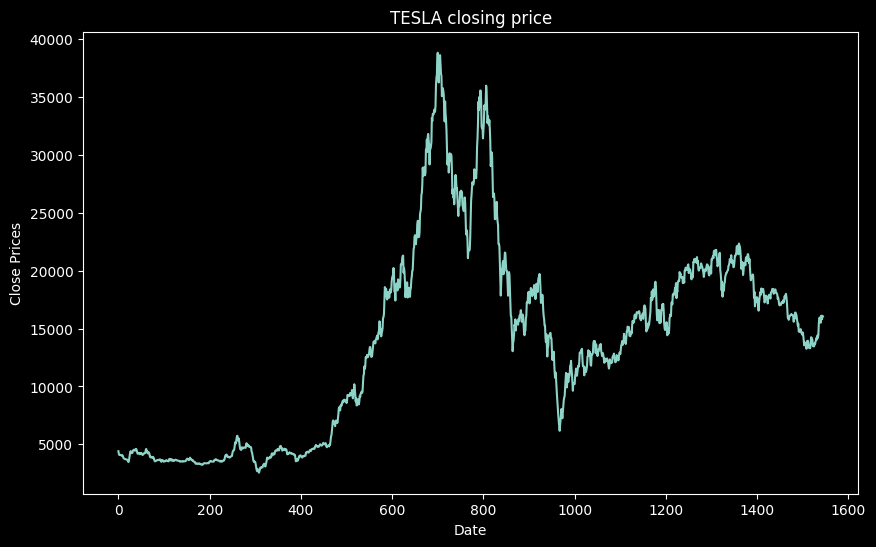

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(close_tsla)
plt.title(' closing price')
plt.show()

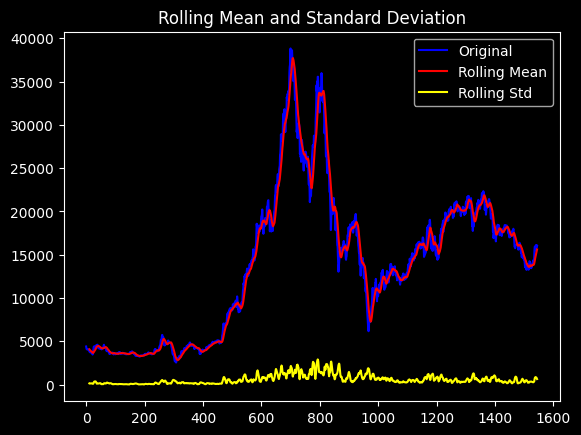

Results of dickey fuller test
Test Statistics                  -1.890192
p-value                           0.336689
No. of lags used                 24.000000
Number of observations used    1520.000000
critical value (1%)              -3.434659
critical value (5%)              -2.863443
critical value (10%)             -2.567783
dtype: float64


In [ ]:
test_stationarity(close_tsla)

## Train, test, valid

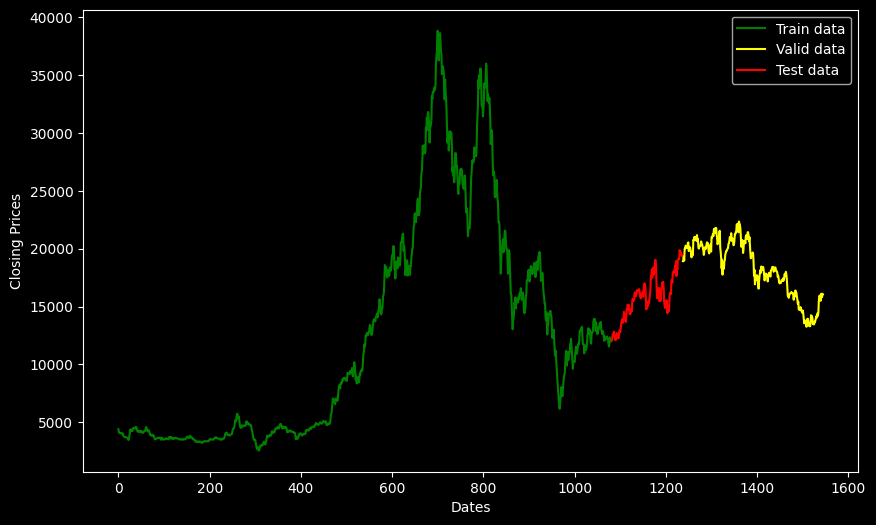

In [ ]:
close_tsla = close_tsla.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_tsla)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [ ]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [ ]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_tsla[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=23932.463, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16528.521, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16528.200, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=16529.364, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=16528.334, Time=0.63 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16527.725, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=3.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16527.378, Time=0.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=1.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=16529.240, Time=0.32 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=16524.266, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=2.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=16520.360, Time=0.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(0,0,0)[0]             : AIC=16505.792, Time=1.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=16518.317, Time=1.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,4)(0,0,0)[0]             : AIC=16483.381, Time=3.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(0,0,0)[0]             : AIC=16516.490, Time=4.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(0,0,0)[0]             : AIC=16513.418, Time=4.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,5)(0,0,0)[0]             : AIC=16511.752, Time=2.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,5)(0,0,0)[0]             : AIC=16507.877, Time=0.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(0,0,0)[0]             : AIC=16481.987, Time=2.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0]             : AIC=16506.964, Time=5.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=16504.531, Time=1.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=16489.131, Time=3.78 sec

Best model:  ARIMA(5,0,3)(0,0,0)[0]          
Total fit time: 41.860 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1081
Model:               SARIMAX(5, 0, 3)   Log Likelihood               -8231.993
Date:                Sun, 13 Apr 2025   AIC                          16481.987
Time:                        10:56:04   BIC                          16526.858
Sample:                             0   HQIC                         16498.976
                               - 1081                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1604      0.071     30.496      0.000       2.022       2.299
ar.L2         -2.3972      0.113    -21.173      0.000      -2.619      -2.175
ar.L3          2.2266      0.118     18.937      0.000       1.996       2.457
ar.L4         -1.0626      0.103    -10.280      0.000      -1.265      -0.860
ar.L5          0.0726      0.031      2.371      0.018       0.013       0.133
ma.L1         -1.0255      0.066    -15.629      0.000      -1.154      -0.897
ma.L2          1.1050      0.020     54.302      0.000       1.065       1.145
ma.L3         -0.8237      0.063    -13.059      0.000      -0.947      -0.700
sigma2      2.496e+05   4.83e-07   5.17e+11      0.000     2.5e+05     2.5e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               469.55
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              45.34   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.03e+27. Standard errors may be unstable.
"""

### Build model

In [ ]:
model = ARIMA(y_train, order=(1,0,1),exog=df_tsla[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1081
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7337.771
Date:                Sun, 13 Apr 2025   AIC                          14689.543
Time:                        10:56:30   BIC                          14724.442
Sample:                             0   HQIC                         14702.757
                               - 1081                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4423     16.713     -0.206      0.837     -36.200      29.315
High           0.8572      0.014     59.759      0.000       0.829       0.885
Open          -0.7143      0.014    -49.620      0.000      -0.742      -0.686
Low            0.8561      0.013     66.689      0.000       0.831       0.881
ar.L1          0.4003      0.188      2.133      0.033       0.033       0.768
ma.L1         -0.4778      0.181     -2.633      0.008      -0.833      -0.122
sigma2      4.648e+04   1114.116     41.722      0.000    4.43e+04    4.87e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.43   Jarque-Bera (JB):              1551.71
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):              36.67   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_tsla[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=df_tsla[['High','Open','Low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [ ]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  171.49898573484452
MAPE:  1.055790500923404
RMSE:  231.8541655571797

** Validate **
MAE:  131.99343298807997
MAPE:  0.7078550973111111
RMSE:  174.41776176533222


## Forecast

####CÁCH 1 – DỰ BÁO TIẾP NỐI TỪ DỮ LIỆU THẬT
Cách này giả định exog tương lai bằng dữ liệu cũ gần nhất – tức là biến động vẫn theo thực tế gần nhất.


In [ ]:
last_index =  close_tsla.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
# Giả sử mô hình đã train là: model
forecast_days = 30

# Cung cấp exog thật (từ 30 ngày gần nhất để khớp độ dài)
exog_real = df_tsla[['High', 'Open', 'Low']].iloc[-forecast_days:]

# Dự báo tiếp nối
y_next_30_days = model.forecast(
    steps=forecast_days,
    exog=exog_real
)

print("✅ Dự báo tiếp nối với dữ liệu exog thật:")
print(y_next_30_days)


✅ Dự báo tiếp nối với dữ liệu exog thật:
1081    13432.147050
1082    13357.010440
1083    13641.276724
1084    14083.261676
1085    14061.111890
1086    14061.018151
1087    14168.178885
1088    13447.353642
1089    13711.732686
1090    13547.283283
1091    13475.893807
1092    13747.232876
1093    13611.410096
1094    13939.884369
1095    13846.921827
1096    14296.677244
1097    14046.719856
1098    14353.581148
1099    14168.057877
1100    14467.850909
1101    15253.454729
1102    15638.128658
1103    15845.073035
1104    15837.983632
1105    15609.504286
1106    15959.513591
1107    16116.241696
1108    15787.881223
1109    15909.621011
1110    16051.960481
Name: predicted_mean, dtype: float64


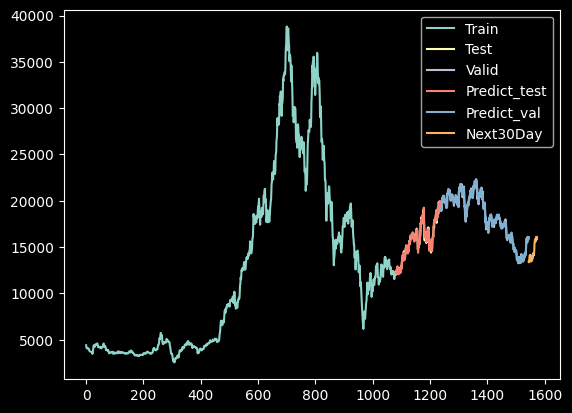

In [ ]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

####CÁCH 2 – DỰ BÁO ĐỘC LẬP NHƯNG MỀM MẠI HƠN

In [ ]:
# Copy lại DataFrame
df = df_tsla.copy()
forecast_days = 30

# Dự báo từng biến exog bằng auto_arima
def forecast_feature(series, n_days):
    model = auto_arima(series,
                       start_p=1, start_q=1,
                       max_p=5, max_q=5,
                       seasonal=False,
                       d=None,
                       trace=False,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
    forecast = model.predict(n_periods=n_days)
    return forecast

# Dự báo High, Open, Low cho 30 ngày tới
forecast_high = forecast_feature(df['High'], forecast_days)
forecast_open = forecast_feature(df['Open'], forecast_days)
forecast_low = forecast_feature(df['Low'], forecast_days)

# Tạo DataFrame exog dự báo
exog_future = pd.DataFrame({
    'High': forecast_high,
    'Open': forecast_open,
    'Low': forecast_low
})

# Dự báo giá Close từ exog đã dự đoán
y_next_30_days = model.forecast(
    steps=forecast_days,
    exog=exog_future
)

print("🔄 Dự báo 30 ngày tới (dùng exog dự báo):")
print(y_next_30_days)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

🔄 Dự báo 30 ngày tới (dùng exog dự báo):
1081    16208.631715
1082    16158.630622
1083    16160.159646
1084    16141.476690
1085    16128.942514
1086    16113.780352
1087    16099.993322
1088    16086.438959
1089    16073.770357
1090    16061.832301
1091    16050.709758
1092    16040.352732
1093    16030.739445
1094    16021.824776
1095    16013.567073
1096    16005.921919
1097    15998.846918
1098    15992.301175
1099    15986.246181
1100    15980.645768
1101    15975.466205
1102    15970.676102
1103    15966.246322
1104    15962.149848
1105    15958.361657
1106    15954.858582
1107    15951.619183
1108    15948.623627
1109    15945.853565
1110    15943.292028
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


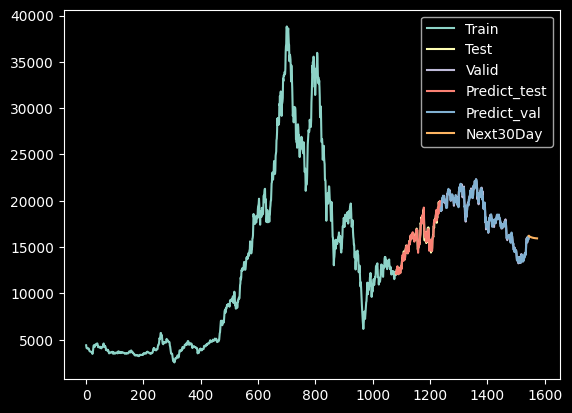

In [ ]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()